M=10: FCFS=0.055, ALT=0.055, LJF=0.055, SJF=0.055, SWIS=0.055
M=210: FCFS=0.668, ALT=0.756, LJF=0.750, SJF=0.580, SWIS=0.784
M=410: FCFS=0.734, ALT=0.752, LJF=0.836, SJF=0.585, SWIS=0.901
M=610: FCFS=0.756, ALT=0.744, LJF=0.859, SJF=0.580, SWIS=0.926
M=810: FCFS=0.769, ALT=0.738, LJF=0.876, SJF=0.575, SWIS=0.943


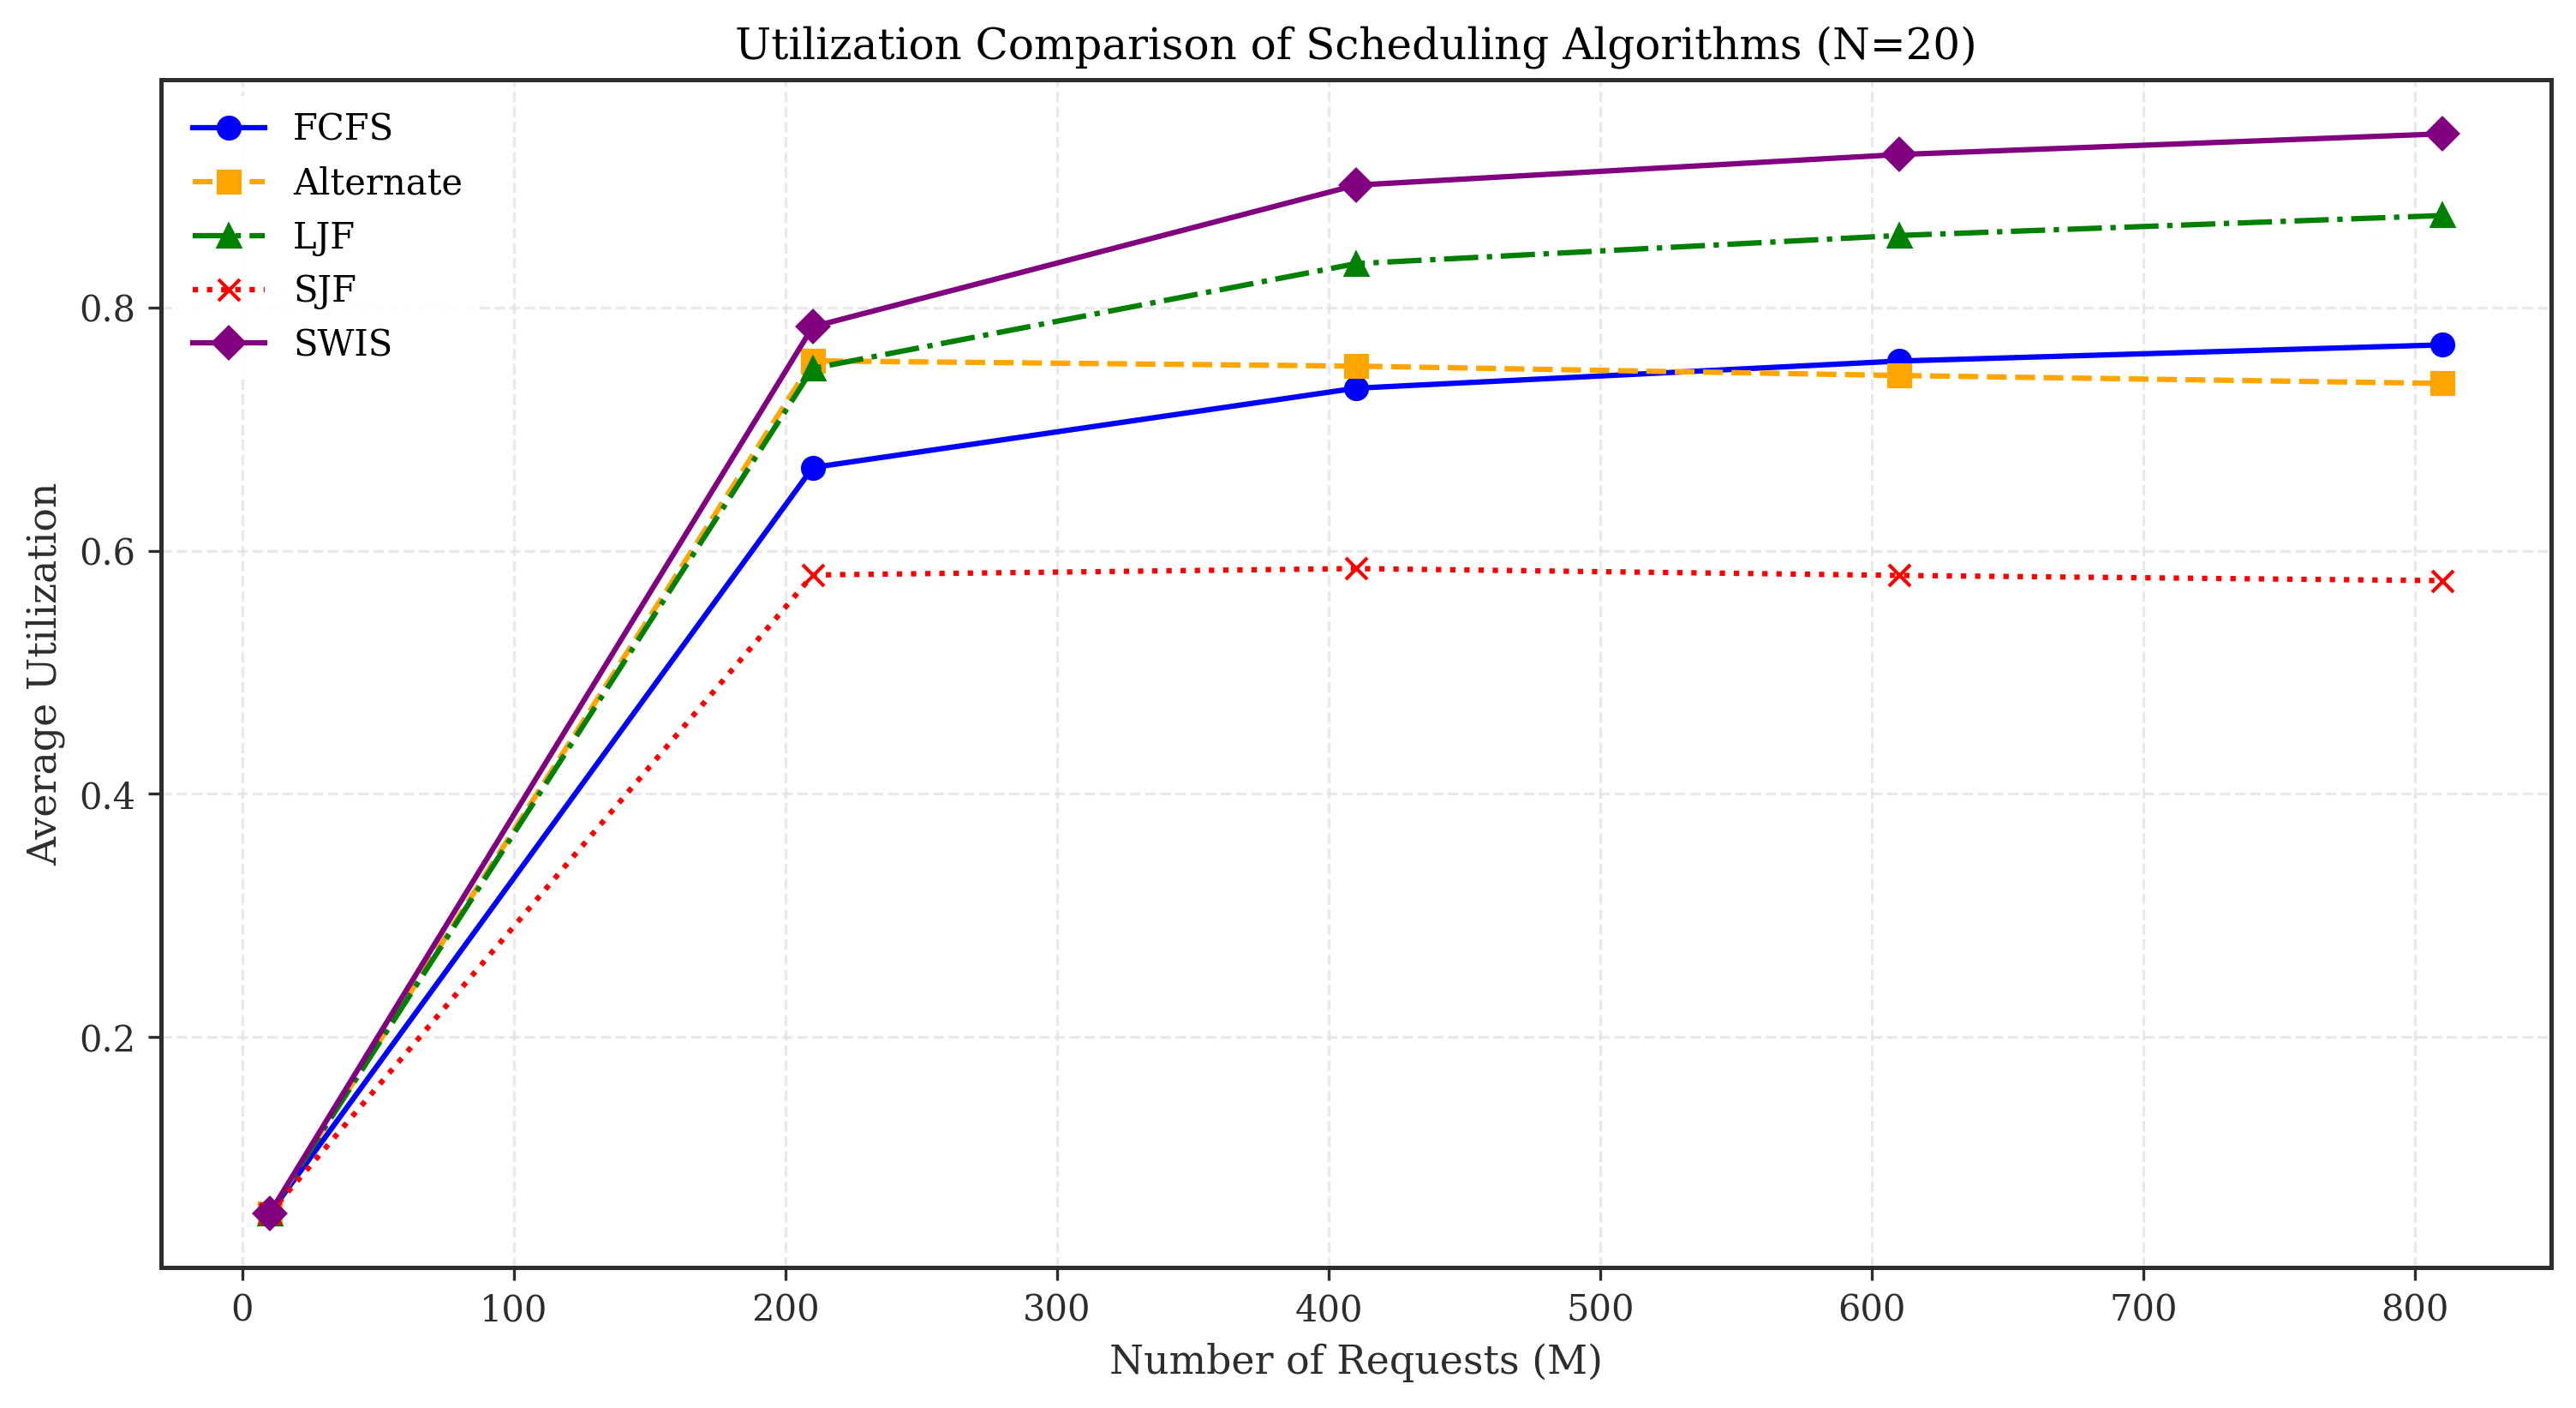

In [65]:
#!/usr/bin/env python3
import random
import matplotlib.pyplot as plt
import bisect

def generate_requests(M, max_L=1000, min_len=1, max_len=200):
    requests = []
    for _ in range(M):
        L = random.randint(1, max_L)
        len_ = random.randint(min_len, max_len)
        R = L + len_ - 1
        requests.append((L, R))
    return requests

def check_overlap(intervals, L_new, R_new):
    for (L, R) in intervals:
        # 如果新区间与已存在区间有交集，返回 True
        if not (R_new < L or L_new > R):
            return True
    return False

# ------------------------------------------------------------------
# 算法 1. FCFS: 按照给定输入顺序逐一尝试插入
def fcfs_algorithm(requests, N):
    resources = [[] for _ in range(N)]
    for req in requests:
        L, R = req
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                break
    return resources

# ------------------------------------------------------------------
# 算法 2. Alternate: 先按起始时间排序，然后如果直接插入失败，
# 尝试替换冲突区间（每个资源仅检查第一个冲突）——见原有实现
def alternative_algorithm(requests, N):
    sorted_requests = sorted(requests, key=lambda x: x[0])
    resources = [[] for _ in range(N)]
    for req in sorted_requests:
        L, R = req
        placed = False
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                placed = True
                break
        if placed:
            continue
        conflict_info = []
        for res_idx, res in enumerate(resources):
            for interval in res:
                Li, Ri = interval
                if not (R < Li or L > Ri):
                    conflict_info.append((res_idx, interval, Ri - Li + 1))
                    break
        if not conflict_info:
            continue
        min_duration = float('inf')
        selected = None
        for info in conflict_info:
            res_idx, interval, duration = info
            if duration < min_duration:
                min_duration = duration
                selected = info
        if selected:
            res_idx, interval, duration_old = selected
            new_duration = R - L + 1
            if new_duration > duration_old:
                temp_res = [iv for iv in resources[res_idx] if iv != interval]
                if not check_overlap(temp_res, L, R):
                    resources[res_idx].remove(interval)
                    resources[res_idx].append((L, R))
    return resources

# ------------------------------------------------------------------
# 算法 3. LJF: 按作业长度（R-L）降序排序，再贪心插入资源
def ljf_algorithm(requests, N):
    sorted_requests = sorted(requests, key=lambda x: (x[1] - x[0]), reverse=True)
    resources = [[] for _ in range(N)]
    for req in sorted_requests:
        L, R = req
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                break
    return resources

# ------------------------------------------------------------------
# 算法 4. SJF: 按作业长度从短到长排序，再贪心插入资源
def sjf_algorithm(requests, N):
    sorted_requests = sorted(requests, key=lambda x: (x[1] - x[0]))
    resources = [[] for _ in range(N)]
    for req in sorted_requests:
        L, R = req
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                break
    return resources

# ------------------------------------------------------------------
# 辅助函数：单机加权区间调度
# 输入：intervals 列表，每个是 (L, R) ；权重为 (R-L+1)
# 输出：获得最优利用率的区间集合（非重叠）
def weighted_interval_scheduling(intervals):
    if not intervals:
        return []
    # 按结束时间升序排序
    sorted_intervals = sorted(intervals, key=lambda x: x[1])
    n = len(sorted_intervals)
    # 计算 p[j]: 对 j 之前最后一个不与 j 重叠的区间的索引
    p = [0] * n
    finish_times = [interval[1] for interval in sorted_intervals]
    for j in range(n):
        # 找到最大的 i < j 满足 sorted_intervals[i][1] < sorted_intervals[j][0]
        i = j - 1
        while i >= 0:
            if sorted_intervals[i][1] < sorted_intervals[j][0]:
                break
            i -= 1
        p[j] = i  # i 可能为 -1 表示没有
    # dp[j] 表示在前 j+1 个区间中取得的最优利用率（总权重）
    dp = [0] * n
    for j in range(n):
        weight = sorted_intervals[j][1] - sorted_intervals[j][0] + 1
        if p[j] >= 0:
            incl = weight + dp[p[j]]
        else:
            incl = weight
        dp[j] = max(incl, dp[j - 1] if j >= 1 else 0)
    # 反向恢复解集
    solution = []
    def recover_solution(j):
        if j < 0:
            return
        weight = sorted_intervals[j][1] - sorted_intervals[j][0] + 1
        if j == 0:
            if weight >= 0:
                solution.append(sorted_intervals[j])
            return
        if weight + (dp[p[j]] if p[j] >= 0 else 0) >= dp[j - 1]:
            solution.append(sorted_intervals[j])
            recover_solution(p[j])
        else:
            recover_solution(j - 1)
    recover_solution(n - 1)
    return sorted(solution, key=lambda x: x[0])  # 按起始时间排序

# ------------------------------------------------------------------
# 算法 5. SWIS (Sequential Weighted Interval Scheduling)
# 思路：对于每个资源，从当前待选集合 U 中用加权区间调度求单机最优安排，
# 将这些请求分配给某资源后，从 U 中删除，再对下一个资源重复此过程。
def swis_algorithm(requests, N):
    # U 表示还未被安排的请求（每个请求只能被使用一次）
    U = requests.copy()
    resources = []
    for i in range(N):
        # 针对当前资源，在 U 中求解单机加权区间调度
        schedule = weighted_interval_scheduling(U)
        resources.append(schedule)
        # 从 U 中删除那些已经安排的请求
        U = [req for req in U if req not in schedule]
        # 如果 U 为空，则后续资源没有安排内容
        if not U:
            # 填充空列表以保持资源个数
            for j in range(i+1, N):
                resources.append([])
            break
    return resources

# ------------------------------------------------------------------
# 利用率计算：按照整个时间窗口 [T_min, T_max] 计算各资源占用时间之和
def calculate_utilization(resources, requests):
    if not requests:
        return 0.0
    T_min = min(req[0] for req in requests)
    T_max = max(req[1] for req in requests)
    T = T_max - T_min + 1 if T_max >= T_min else 0
    if T == 0:
        return 0.0
    N = len(resources)
    total_S = 0
    for res in resources:
        for (L, R) in res:
            total_S += (R - L + 1)
    return total_S / (N * T)

# ------------------------------------------------------------------
# 模拟实验：对不同请求数 M，多次试验，统计各算法的平均利用率
def run_simulation(N, M_values, num_trials=50):
    fcfs_avgs = []
    alt_avgs = []
    ljf_avgs = []
    sjf_avgs = []
    swis_avgs = []
    for M in M_values:
        fcfs_sum = alt_sum = ljf_sum = sjf_sum = swis_sum = 0.0
        for _ in range(num_trials):
            requests = generate_requests(M)
            # 注意：各算法下，利用率的分母总时间 T 是由所有请求决定
            fcfs_resources = fcfs_algorithm(requests, N)
            fcfs_sum += calculate_utilization(fcfs_resources, requests)

            alt_resources = alternative_algorithm(requests, N)
            alt_sum += calculate_utilization(alt_resources, requests)

            ljf_resources = ljf_algorithm(requests, N)
            ljf_sum += calculate_utilization(ljf_resources, requests)

            sjf_resources = sjf_algorithm(requests, N)
            sjf_sum += calculate_utilization(sjf_resources, requests)

            swis_resources = swis_algorithm(requests, N)
            swis_sum += calculate_utilization(swis_resources, requests)

        fcfs_avg = fcfs_sum / num_trials
        alt_avg = alt_sum / num_trials
        ljf_avg = ljf_sum / num_trials
        sjf_avg = sjf_sum / num_trials
        swis_avg = swis_sum / num_trials

        fcfs_avgs.append(fcfs_avg)
        alt_avgs.append(alt_avg)
        ljf_avgs.append(ljf_avg)
        sjf_avgs.append(sjf_avg)
        swis_avgs.append(swis_avg)

        print(f"M={M}: FCFS={fcfs_avg:.3f}, ALT={alt_avg:.3f}, LJF={ljf_avg:.3f}, SJF={sjf_avg:.3f}, SWIS={swis_avg:.3f}")
    return fcfs_avgs, alt_avgs, ljf_avgs, sjf_avgs, swis_avgs

# ------------------------------------------------------------------
# 参数设置与主程序
N = 20
M_values = list(range(10, 1000, 200))
num_trials = 50

fcfs, alt, ljf, sjf, swis = run_simulation(N, M_values, num_trials)

plt.figure(figsize=(12, 6))
plt.plot(M_values, fcfs, marker='o', label='FCFS', color='blue')
plt.plot(M_values, alt, marker='s', linestyle='--', label='Alternate', color='orange')
plt.plot(M_values, ljf, marker='^', linestyle='-.', label='LJF', color='green')
plt.plot(M_values, sjf, marker='x', linestyle=':', label='SJF', color='red')
plt.plot(M_values, swis, marker='D', linestyle='-', label='SWIS', color='purple')

plt.title('Utilization Comparison of Scheduling Algorithms (N={})'.format(N))
plt.xlabel('Number of Requests (M)')
plt.ylabel('Average Utilization')
plt.legend()
plt.grid(True)
plt.show()

M=10: SWIS_SA utilization = 0.203
M=210: SWIS_SA utilization = 0.808
M=410: SWIS_SA utilization = 0.837
M=610: SWIS_SA utilization = 0.872
M=810: SWIS_SA utilization = 0.869


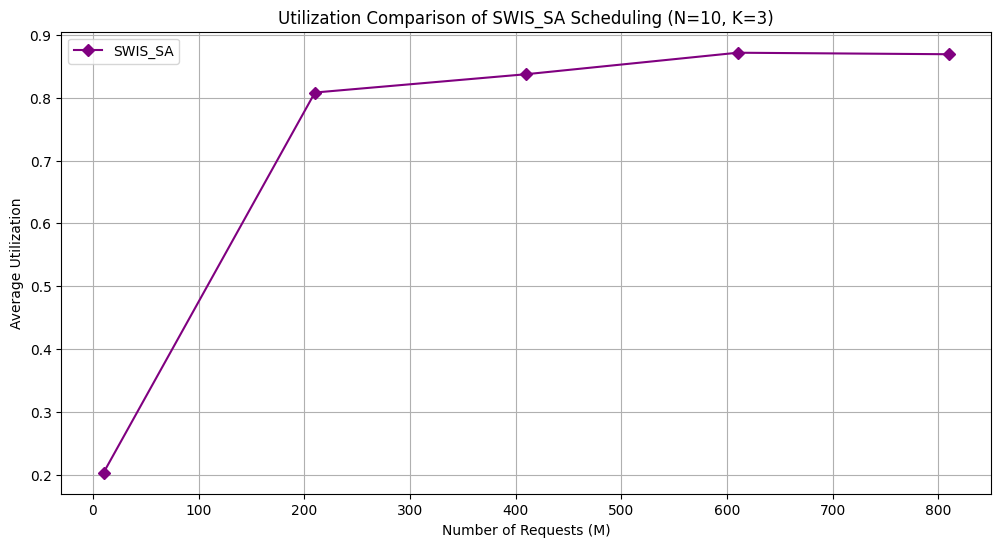

In [5]:
#!/usr/bin/env python3
import random
import math
import matplotlib.pyplot as plt
import bisect

# ------------------------------------------------------------------
# 生成请求，每个请求为 (L, R)
def generate_requests(M, max_L=1000, min_len=1, max_len=200):
    requests = []
    for _ in range(M):
        L = random.randint(1, max_L)
        len_ = random.randint(min_len, max_len)
        R = L + len_ - 1
        requests.append((L, R))
    return requests

# 检查新区间是否与当前 intervals 有交叠
def check_overlap(intervals, L_new, R_new):
    for (L, R) in intervals:
        # 若新区间与已有区间有交集，返回 True
        if not (R_new < L or L_new > R):
            return True
    return False

# ------------------------------------------------------------------
# 算法 1. FCFS: 按给定顺序逐一尝试插入
def fcfs_algorithm(requests, N):
    resources = [[] for _ in range(N)]
    for req in requests:
        L, R = req
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                break
    return resources

# ------------------------------------------------------------------
# 算法 2. Alternate
def alternative_algorithm(requests, N):
    sorted_requests = sorted(requests, key=lambda x: x[0])
    resources = [[] for _ in range(N)]
    for req in sorted_requests:
        L, R = req
        placed = False
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                placed = True
                break
        if placed:
            continue
        conflict_info = []
        for res_idx, res in enumerate(resources):
            for interval in res:
                Li, Ri = interval
                if not (R < Li or L > Ri):
                    conflict_info.append((res_idx, interval, Ri - Li + 1))
                    break
        if not conflict_info:
            continue
        min_duration = float('inf')
        selected = None
        for info in conflict_info:
            res_idx, interval, duration = info
            if duration < min_duration:
                min_duration = duration
                selected = info
        if selected:
            res_idx, interval, duration_old = selected
            new_duration = R - L + 1
            if new_duration > duration_old:
                temp_res = [iv for iv in resources[res_idx] if iv != interval]
                if not check_overlap(temp_res, L, R):
                    resources[res_idx].remove(interval)
                    resources[res_idx].append((L, R))
    return resources

# ------------------------------------------------------------------
# 算法 3. LJF: 按作业长度（R-L）降序排序，再贪心插入资源
def ljf_algorithm(requests, N):
    sorted_requests = sorted(requests, key=lambda x: (x[1] - x[0]), reverse=True)
    resources = [[] for _ in range(N)]
    for req in sorted_requests:
        L, R = req
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                break
    return resources

# ------------------------------------------------------------------
# 算法 4. SJF: 按作业长度（R-L）升序排序，再贪心插入资源
def sjf_algorithm(requests, N):
    sorted_requests = sorted(requests, key=lambda x: (x[1] - x[0]))
    resources = [[] for _ in range(N)]
    for req in sorted_requests:
        L, R = req
        for res in resources:
            if not check_overlap(res, L, R):
                res.append((L, R))
                break
    return resources

# ------------------------------------------------------------------
# 辅助函数：单机加权区间调度（DP）
def weighted_interval_scheduling(intervals):
    if not intervals:
        return []
    sorted_intervals = sorted(intervals, key=lambda x: x[1])
    n = len(sorted_intervals)
    p = [0] * n
    finish_times = [interval[1] for interval in sorted_intervals]
    for j in range(n):
        i = j - 1
        while i >= 0:
            if sorted_intervals[i][1] < sorted_intervals[j][0]:
                break
            i -= 1
        p[j] = i
    dp = [0] * n
    for j in range(n):
        weight = sorted_intervals[j][1] - sorted_intervals[j][0] + 1
        if p[j] >= 0:
            incl = weight + dp[p[j]]
        else:
            incl = weight
        dp[j] = max(incl, dp[j - 1] if j >= 1 else 0)
    solution = []
    def recover_solution(j):
        if j < 0:
            return
        weight = sorted_intervals[j][1] - sorted_intervals[j][0] + 1
        if j == 0:
            if weight >= 0:
                solution.append(sorted_intervals[j])
            return
        if weight + (dp[p[j]] if p[j] >= 0 else 0) >= dp[j - 1]:
            solution.append(sorted_intervals[j])
            recover_solution(p[j])
        else:
            recover_solution(j - 1)
    recover_solution(n - 1)
    return sorted(solution, key=lambda x: x[0])

# ------------------------------------------------------------------
# 算法 5. SWIS (Sequential Weighted Interval Scheduling)
def swis_algorithm(requests, N):
    U = requests.copy()
    resources = []
    for i in range(N):
        schedule = weighted_interval_scheduling(U)
        resources.append(schedule)
        U = [req for req in U if req not in schedule]
        if not U:
            for j in range(i+1, N):
                resources.append([])
            break
    return resources

# ------------------------------------------------------------------
# 原有计算利用率函数（单类资源）
def calculate_utilization(resources, requests):
    if not requests:
        return 0.0
    T_min = min(req[0] for req in requests)
    T_max = max(req[1] for req in requests)
    T = T_max - T_min + 1 if T_max >= T_min else 0
    if T == 0:
        return 0.0
    total_S = 0
    for res in resources:
        for (L, R) in res:
            total_S += (R - L + 1)
    return total_S / (len(resources) * T)

# ------------------------------------------------------------------
# 以下为模拟退火改进版 SWIS 算法
# 思想：先用 SWIS (第一类资源，共 N 个) 得到原始候选集合 S_cat1
# 然后针对第二至第四类资源（各 K 个），要求调度结果非重叠
# 条件为“任一时刻并发数 <= K”
# 模拟退火过程随机尝试将 S_cat1 中被删除的区间以 50% 概率加入，再删除冲突区间（随机删除冲突区间），采用退火准则决定是否接受新方案

# 判断给定区间集合是否可以在 K 个机器上调度（即任一时刻并发数不超过 K）
def is_feasible(intervals, K):
    if not intervals:
        return True
    events = []
    for (L, R) in intervals:
        events.append((L, 1))
        events.append((R+1, -1))
    events.sort(key=lambda x: x[0])
    count = 0
    for t, delta in events:
        count += delta
        if count > K:
            return False
    return True

# 当区间集合 candidate 在 K 个机器上不可行时，随机删除“冲突区间”直到可行
def resolve_conflicts(intervals, K):
    candidate = intervals.copy()
    while not is_feasible(candidate, K):
        events = []
        for iv in candidate:
            L, R = iv
            events.append((L, 1))
            events.append((R+1, -1))
        events.sort(key=lambda x: x[0])
        count = 0
        conflict_time = None
        for t, delta in events:
            count += delta
            if count > K:
                conflict_time = t
                break
        if conflict_time is None:
            break
        # 找出覆盖冲突时刻 conflict_time 的所有区间
        conflict_intervals = [iv for iv in candidate if iv[0] <= conflict_time <= iv[1]]
        if conflict_intervals:
            iv_remove = random.choice(conflict_intervals)
            candidate.remove(iv_remove)
        else:
            break
    return candidate

# 给定一组区间，将其分配到 K 个机器上（贪心分配，保证无冲突，前提是该集合满足最大并发数不超过 K）
def assign_intervals(intervals, K):
    sorted_intervals = sorted(intervals, key=lambda iv: iv[0])
    resources = [[] for _ in range(K)]
    for iv in sorted_intervals:
        L, R = iv
        placed = False
        for res in resources:
            if not check_overlap(res, L, R):
                res.append(iv)
                placed = True
                break
        if not placed:
            # 理论上若集合可行，应该不会出现
            pass
    return resources

# SWIS 模拟退火改进版
# 输入：requests，第一类资源个数 N，其他每类 K 个资源
def swis_sa_algorithm(requests, N, K, num_iter=1000, init_temp=100.0, alpha=0.95):
    # 先用 SWIS 得到第一类资源的调度方案
    swis_res = swis_algorithm(requests, N)
    # S_cat1 表示第一类资源调度中所有被选中的请求集合（每个请求只出现一次）
    S_cat1_set = set()
    for res in swis_res:
        for iv in res:
            S_cat1_set.add(iv)
    # 将 S_cat1_set 转成列表
    S_cat1 = list(S_cat1_set)
    # 初始模拟退火状态：从 S_cat1 中删除冲突区间，使其在 K 个机器上可调度
    current_state = resolve_conflicts(S_cat1, K)
    current_state_set = set(current_state)
    current_obj = sum(iv[1]-iv[0]+1 for iv in current_state)
    best_state = current_state[:]
    best_obj = current_obj

    T = init_temp
    for _ in range(num_iter):
        # 邻域产生：从目前状态之外的区间以 50% 概率加回来
        candidate_set = set(current_state_set)
        for iv in S_cat1_set - current_state_set:
            if random.random() < 0.5:
                candidate_set.add(iv)
        candidate_list = list(candidate_set)
        candidate_feasible = resolve_conflicts(candidate_list, K)
        candidate_obj = sum(iv[1]-iv[0]+1 for iv in candidate_feasible)
        delta = candidate_obj - current_obj
        if delta >= 0 or (T > 0 and random.random() < math.exp(delta/T)):
            current_state_set = set(candidate_feasible)
            current_obj = candidate_obj
            if candidate_obj > best_obj:
                best_state = candidate_feasible[:]
                best_obj = candidate_obj
        T = T * alpha
    # 用最终得到的区间集合 best_state，在第二至第四类资源上进行贪心分配
    res2 = assign_intervals(best_state, K)
    res3 = assign_intervals(best_state, K)
    res4 = assign_intervals(best_state, K)
    # 返回一个列表，包含四类资源的分配情况：
    # 第一类：原始 SWIS 调度方案（共 N 个资源）；
    # 其他三类：模拟退火后各自分配到 K 个资源上
    return [swis_res, res2, res3, res4]

# 组合多类资源的利用率计算函数
# 这里总资源数 = N + 3*K，时间窗口和所有请求有关
def calculate_combined_utilization(resources_multi, requests, N, K):
    if not requests:
        return 0.0
    T_min = min(req[0] for req in requests)
    T_max = max(req[1] for req in requests)
    T = T_max - T_min + 1 if T_max >= T_min else 0
    total_occupied = 0
    for resource_category in resources_multi:
        for resource in resource_category:
            for (L, R) in resource:
                total_occupied += (R - L + 1)
    total_resources = N + 3*K
    return total_occupied / (total_resources * T)

# 模拟实验：对于不同请求数 M，多次试验，统计改进版 SWIS_SA 算法的平均占用率
def run_simulation_sa(N, K, M_values, num_trials=50):
    sa_avgs = []
    for M in M_values:
        sa_sum = 0.0
        for _ in range(num_trials):
            requests = generate_requests(M)
            # 得到四类资源的调度：第一类用 SWIS，其他三类经模拟退火
            multi_resources = swis_sa_algorithm(requests, N, K)
            util = calculate_combined_utilization(multi_resources, requests, N, K)
            sa_sum += util
        sa_avg = sa_sum / num_trials
        print(f"M={M}: SWIS_SA utilization = {sa_avg:.3f}")
        sa_avgs.append(sa_avg)
    return sa_avgs

# ------------------------------------------------------------------
# 主程序参数设置与仿真实验
if __name__ == '__main__':
    # 第一类资源数
    N = 10
    # 第二至第四类资源数（各 K 个）
    K = 3
    M_values = list(range(10, 1000, 200))
    num_trials = 3

    sa_util = run_simulation_sa(N, K, M_values, num_trials)

    plt.figure(figsize=(12, 6))
    plt.plot(M_values, sa_util, marker='D', linestyle='-', label='SWIS_SA', color='purple')

    plt.title('Utilization Comparison of SWIS_SA Scheduling (N={}, K={})'.format(N, K))
    plt.xlabel('Number of Requests (M)')
    plt.ylabel('Average Utilization')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
#!/usr/bin/env python3
import random
import math
import matplotlib.pyplot as plt
import bisect

# ------------------------------------------------------------------
# 生成多类资源请求
# 每个请求生成 (L, R, req_types)；
# 固定要求类别1，类别2~4按概率 p 随机决定是否需要
def generate_requests_multi(M, max_L=1000, min_len=1, max_len=200, p=0.5):
    requests = []
    for _ in range(M):
        L = random.randint(1, max_L)
        dur = random.randint(min_len, max_len)
        R = L + dur - 1
        req_types = [1]  # 类别1始终需要
        for rtype in [2, 3, 4]:
            if random.random() < p:
                req_types.append(rtype)
        req_types = tuple(sorted(req_types))
        requests.append((L, R, req_types))
    return requests

# ------------------------------------------------------------------
# 检查新区间 [L_new, R_new] 是否与 intervals 中某区间冲突
def check_overlap(intervals, L_new, R_new):
    for interval in intervals:
        L = interval[0]
        R = interval[1]
        if not (R_new < L or L_new > R):
            return True
    return False

# ------------------------------------------------------------------
# 辅助：给定资源列表（各机器的任务列表），寻找第一个能插入 [L,R] 的机器（无重叠）
def find_slot(resource_list, L, R):
    for idx, machine in enumerate(resource_list):
        if not check_overlap(machine, L, R):
            return idx
    return None

# ------------------------------------------------------------------
# FCFS_multi：按照生成顺序贪心安排，每个请求要求全部需要的资源都能安排
# 各类别的资源数：类别1：N，类别2~4：K（每类）
def fcfs_multi(requests, N, K):
    # 为各类资源建立空的机器列表
    resources = {
        1: [ [] for _ in range(N) ],
        2: [ [] for _ in range(K) ],
        3: [ [] for _ in range(K) ],
        4: [ [] for _ in range(K) ]
    }
    for req in requests:
        L, R, req_types = req
        chosen = {}  # 记录每个类别选中的机器编号
        feasible = True
        for rtype in req_types:
            slot = find_slot(resources[rtype], L, R)
            if slot is None:
                feasible = False
                break
            else:
                chosen[rtype] = slot
        if feasible:
            for rtype in req_types:
                resources[rtype][chosen[rtype]].append(req)
    # 统一返回一个列表，顺序为类别1, 类别2, 类别3, 类别4
    return [resources[1], resources[2], resources[3], resources[4]]

# ------------------------------------------------------------------
# LJF_multi：先按照任务“长度”降序排序再贪心安排
# 任务长度定义为：持续时间 * (所需的资源种类数)
# 若相同则选择要求资源种类数多的请求
def ljf_multi(requests, N, K):
    def job_key(req):
        L, R, req_types = req
        duration = R - L + 1
        count = len(req_types)
        return (duration * count, count)
    sorted_requests = sorted(requests, key=job_key, reverse=True)
    resources = {
        1: [ [] for _ in range(N) ],
        2: [ [] for _ in range(K) ],
        3: [ [] for _ in range(K) ],
        4: [ [] for _ in range(K) ]
    }
    for req in sorted_requests:
        L, R, req_types = req
        chosen = {}
        feasible = True
        for rtype in req_types:
            slot = find_slot(resources[rtype], L, R)
            if slot is None:
                feasible = False
                break
            else:
                chosen[rtype] = slot
        if feasible:
            for rtype in req_types:
                resources[rtype][chosen[rtype]].append(req)
    return [resources[1], resources[2], resources[3], resources[4]]

# ------------------------------------------------------------------
# 单机加权区间调度（DP求解最优不重叠区间序列）
# 注意：这里假设每个请求元组的前两个元素表示 [L, R]
def weighted_interval_scheduling(intervals):
    if not intervals:
        return []
    sorted_intervals = sorted(intervals, key=lambda x: x[1])
    n = len(sorted_intervals)
    p = [0] * n
    for j in range(n):
        i = j - 1
        while i >= 0:
            if sorted_intervals[i][1] < sorted_intervals[j][0]:
                break
            i -= 1
        p[j] = i
    dp = [0] * n
    for j in range(n):
        weight = sorted_intervals[j][1] - sorted_intervals[j][0] + 1
        incl = weight + (dp[p[j]] if p[j] >= 0 else 0)
        dp[j] = incl if (j == 0 or incl > dp[j - 1]) else dp[j - 1]
    solution = []
    def recover(j):
        if j < 0:
            return
        weight = sorted_intervals[j][1] - sorted_intervals[j][0] + 1
        if j == 0:
            solution.append(sorted_intervals[j])
            return
        if weight + (dp[p[j]] if p[j] >= 0 else 0) >= dp[j - 1]:
            solution.append(sorted_intervals[j])
            recover(p[j])
        else:
            recover(j - 1)
    recover(n - 1)
    return sorted(solution, key=lambda x: x[0])

# ------------------------------------------------------------------
# SWIS算法：基于单类资源（类别1）进行调度
def swis_algorithm(requests, N):
    U = requests.copy()
    resources = []
    for i in range(N):
        schedule = weighted_interval_scheduling(U)
        resources.append(schedule)
        U = [req for req in U if req not in schedule]
        if not U:
            for j in range(i + 1, N):
                resources.append([])
            break
    return resources

# ------------------------------------------------------------------
# 以下为用于模拟退火处理第二至第四类资源的辅助函数
# 判断给定区间集合是否可在 K 个机器（无重叠）上排布（扫描线法）
def is_feasible(intervals, K):
    if not intervals:
        return True
    events = []
    for iv in intervals:
        L, R = iv[0], iv[1]
        events.append((L, 1))
        events.append((R + 1, -1))
    events.sort(key=lambda x: x[0])
    count = 0
    for t, delta in events:
        count += delta
        if count > K:
            return False
    return True

# 冲突时“随机删除”覆盖冲突时刻的一个区间，直到可行
def resolve_conflicts(intervals, K):
    candidate = intervals.copy()
    while not is_feasible(candidate, K):
        events = []
        for iv in candidate:
            L, R = iv[0], iv[1]
            events.append((L, 1))
            events.append((R + 1, -1))
        events.sort(key=lambda x: x[0])
        count = 0
        conflict_time = None
        for t, delta in events:
            count += delta
            if count > K:
                conflict_time = t
                break
        if conflict_time is None:
            break
        # 找到覆盖冲突时刻的所有区间，随机删除其中一个
        conflict_intervals = [iv for iv in candidate if iv[0] <= conflict_time <= iv[1]]
        if conflict_intervals:
            iv_remove = random.choice(conflict_intervals)
            candidate.remove(iv_remove)
        else:
            break
    return candidate

# 给定一组区间，将其分配到 K 台机器上（贪心分配）
def assign_intervals(intervals, K):
    sorted_intervals = sorted(intervals, key=lambda iv: iv[0])
    resources = [[] for _ in range(K)]
    for iv in sorted_intervals:
        L, R = iv[0], iv[1]
        for machine in resources:
            if not check_overlap(machine, L, R):
                machine.append(iv)
                break
    return resources

# ------------------------------------------------------------------
# SWIS_SA 改进版本：
# ① 先在类别1上用 SWIS 得到候选集合 S_cat1（所有请求均要求类别1）；
# ② 对 S_cat1 用模拟退火处理，确保在第二至第四类（每类 K 台）上无冲突；
# ③ 最后分别在各类别上（类别1直接利用 assign_intervals，类别2~4只安排那些需要该类别的请求）进行贪心分配
def swis_sa_algorithm(requests, N, K, num_iter=1000, init_temp=100.0, alpha=0.95):
    # 先利用 SWIS 在类别1上调度（所有请求均要求类别1）
    swis_res = swis_algorithm(requests, N)
    S_cat1_set = set()
    for res in swis_res:
        for iv in res:
            S_cat1_set.add(iv)
    S_cat1 = list(S_cat1_set)
    # 初始状态：冲突解决后，使其在 K 台机器上可排布
    current_state = resolve_conflicts(S_cat1, K)
    current_state_set = set(current_state)
    current_obj = sum(iv[1] - iv[0] + 1 for iv in current_state)
    best_state = current_state[:]
    best_obj = current_obj
    T = init_temp
    for _ in range(num_iter):
        # 邻域：对于当前状态外的区间以 50% 概率尝试加入
        candidate_set = set(current_state_set)
        for iv in S_cat1_set - current_state_set:
            if random.random() < 0.5:
                candidate_set.add(iv)
        candidate_list = list(candidate_set)
        candidate_feasible = resolve_conflicts(candidate_list, K)
        candidate_obj = sum(iv[1] - iv[0] + 1 for iv in candidate_feasible)
        delta = candidate_obj - current_obj
        if delta >= 0 or (T > 0 and random.random() < math.exp(delta / T)):
            current_state_set = set(candidate_feasible)
            current_obj = candidate_obj
            if candidate_obj > best_obj:
                best_state = candidate_feasible[:]
                best_obj = candidate_obj
        T = T * alpha
    # 利用最终得到的 best_state 分配各类别
    res1 = assign_intervals(best_state, N)  # 类别1
    # 类别2~4：只安排那些要求该类别的请求
    res2 = assign_intervals([iv for iv in best_state if 2 in iv[2]], K)
    res3 = assign_intervals([iv for iv in best_state if 3 in iv[2]], K)
    res4 = assign_intervals([iv for iv in best_state if 4 in iv[2]], K)
    return [res1, res2, res3, res4]

# ------------------------------------------------------------------
# 计算多类资源调度的总体利用率：
# 时间窗口取所有请求最早开始时刻到最晚结束时刻，
# 分母为： (N + 3*K) * T
def calculate_combined_utilization(resources_multi, requests, N, K):
    if not requests:
        return 0.0
    T_min = min(req[0] for req in requests)
    T_max = max(req[1] for req in requests)
    T = T_max - T_min + 1 if T_max >= T_min else 0
    total_occupied = 0
    for category in resources_multi:
        for machine in category:
            for iv in machine:
                total_occupied += (iv[1] - iv[0] + 1)
    total_resources = N + 3 * K
    return total_occupied / (total_resources * T)

# ------------------------------------------------------------------
# 模拟实验：针对不同请求数 M，多次实验统计三种算法的平均利用率
def run_simulation_multi(N, K, M_values, num_trials=50):
    fcfs_avgs = []
    ljf_avgs = []
    sa_avgs = []
    for M in M_values:
        fcfs_sum = 0.0
        ljf_sum = 0.0
        sa_sum = 0.0
        for _ in range(num_trials):
            requests = generate_requests_multi(M)
            # FCFS_multi
            fcfs_resources = fcfs_multi(requests, N, K)
            fcfs_sum += calculate_combined_utilization(fcfs_resources, requests, N, K)
            # LJF_multi
            ljf_resources = ljf_multi(requests, N, K)
            ljf_sum += calculate_combined_utilization(ljf_resources, requests, N, K)
            # SWIS_SA
            sa_resources = swis_sa_algorithm(requests, N, K)
            sa_sum += calculate_combined_utilization(sa_resources, requests, N, K)
        fcfs_avg = fcfs_sum / num_trials
        ljf_avg = ljf_sum / num_trials
        sa_avg = sa_sum / num_trials
        print(f"M={M}: FCFS={fcfs_avg:.3f}, LJF={ljf_avg:.3f}, SWIS_SA={sa_avg:.3f}")
        fcfs_avgs.append(fcfs_avg)
        ljf_avgs.append(ljf_avg)
        sa_avgs.append(sa_avg)
    return fcfs_avgs, ljf_avgs, sa_avgs

# ------------------------------------------------------------------
# 主程序：参数设置与结果绘图
if __name__ == '__main__':
    # 第一类资源数
    N = 10
    # 第二至第四类资源数（每类）
    K = 3
    # 不同请求数 M
    M_values = list(range(10, 1000, 200))
    num_trials = 3

    fcfs_util, ljf_util, sa_util = run_simulation_multi(N, K, M_values, num_trials)

    plt.figure(figsize=(12, 6))
    plt.plot(M_values, fcfs_util, marker='o', linestyle='-', label='FCFS', color='blue')
    plt.plot(M_values, ljf_util, marker='s', linestyle='--', label='LJF', color='orange')
    plt.plot(M_values, sa_util, marker='D', linestyle='-', label='SWIS_SA', color='purple')

    plt.title('Combined Utilization Comparison (N={}, K={})'.format(N, K))
    plt.xlabel('Number of Requests (M)')
    plt.ylabel('Average Utilization')
    plt.legend()
    plt.grid(True)
    plt.show()

M=10: FCFS=0.150, LJF=0.150, SWIS_SA=0.146
M=210: FCFS=0.573, LJF=0.624, SWIS_SA=0.274
M=410: FCFS=0.647, LJF=0.754, SWIS_SA=0.298


KeyboardInterrupt: 